# New York City Taxi Trip Duration


- You can find the full project & the dataset at: https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview

# Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
sns.set()
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

# Importing data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv(r"val.csv")

# Understanding dataset

## Column Descriptions

- **id:** A unique identifier for each trip
- **vendor_id:** A code indicating the provider associated with the trip record
- **pickup_datetime:** The date and time when the meter was engaged
- **dropoff_datetime:** The date and time when the meter was disengaged
- **passenger_count:** The number of passengers in the vehicle (driver entered value)
- **pickup_longitude:** The longitude where the meter was engaged
- **pickup_latitude:** The latitude where the meter was engaged
- **dropoff_longitude:** The longitude where the meter was disengaged
- **dropoff_latitude:** The latitude where the meter was disengaged
- **store_and_fwd_flag:** This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- **trip_duration:** Duration of the trip in seconds



### Inspecting Datasets

In [3]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


- look to the **trip duration** you will found that the min is 1 second and max is 2227612 == 618.7 hours and thats not logically



# Cleaning Data

### Check null values

In [6]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Check duplicated values

In [7]:
print("Total duplicated values are '",train.duplicated().sum(), "'")

Total duplicated values are ' 0 '


### Check outliers values

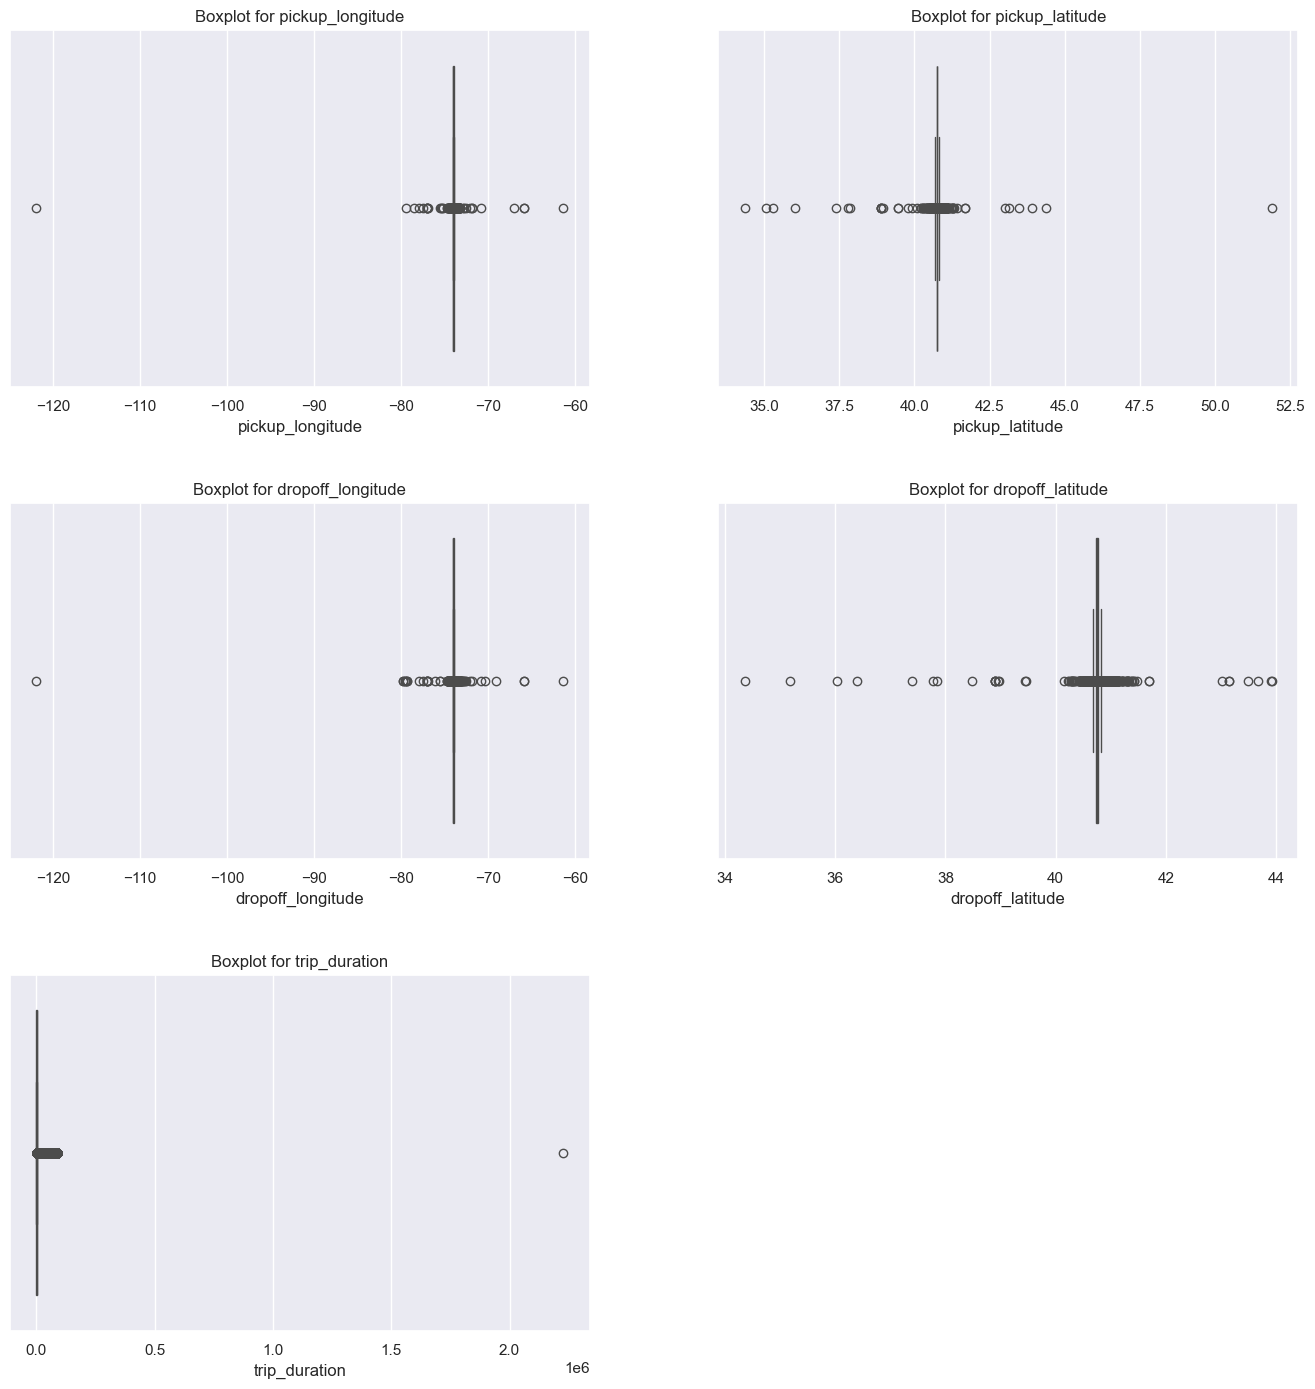

In [8]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
            'dropoff_latitude', 'trip_duration']

num_features = len(features)
cols = 2  
rows = (num_features + 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

fig.tight_layout(pad=5)

for i, column in enumerate(features):
    row = i // cols
    col = i % cols  
    
    sns.boxplot(data=train, x=column, ax=axes[row, col])
    axes[row, col].set_title(f"Boxplot for {column}")
   

if num_features % cols != 0:
    for j in range(num_features, rows * cols):
        fig.delaxes(axes.flatten()[j])

plt.show()

### Trip Duration outliers clean

- "First, I will clean the trip_duration (target column) using the standard deviation."

In [9]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

### Latitude and Longitude outliers clean

- By searching on Google, we find that the coordinates for New York are:

- Longitude borders: (-74.03, -73.75)
- Latitude borders: (40.63, 40.85)

In [10]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

### Passenger_Count outliers clean

In [11]:
train[train['passenger_count']==0]=np.nan
train.dropna(axis=0,inplace=True)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985109 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  985109 non-null  object 
 1   vendor_id           985109 non-null  float64
 2   pickup_datetime     985109 non-null  object 
 3   passenger_count     985109 non-null  float64
 4   pickup_longitude    985109 non-null  float64
 5   pickup_latitude     985109 non-null  float64
 6   dropoff_longitude   985109 non-null  float64
 7   dropoff_latitude    985109 non-null  float64
 8   store_and_fwd_flag  985109 non-null  object 
 9   trip_duration       985109 non-null  float64
dtypes: float64(7), object(3)
memory usage: 82.7+ MB


# Feature Engineering

### Data transform

- in the first we will extract the data from the datetime colomns 

In [13]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day

train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

train['month'] = train['pickup_datetime'].dt.month
test['month'] = test['pickup_datetime'].dt.month

train['hour'] = train['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour

train['dayofyear'] = train['pickup_datetime'].dt.dayofyear
test['dayofyear'] = test['pickup_datetime'].dt.dayofyear

### Distance and Direction

- Using Longitude and Latitude, we will create new features such as Haversine distance, Manhattan distance, and Direction

#### Haversine distance

In [14]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

-The function **haversine** calculates the Haversine distance between two sets of latitude and longitude coordinates. The Haversine formula is used to compute the distance between two points on a sphere (such as the Earth) given their latitude and longitude.

In [15]:
train['distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                            train['pickup_longitude'].values,
                                            train['dropoff_latitude'].values,
                                            train['dropoff_longitude'].values)

test['distance_haversine'] = haversine_array(test['pickup_latitude'].values,
                                            test['pickup_longitude'].values,
                                            test['dropoff_latitude'].values,
                                            test['dropoff_longitude'].values)


#### Manhattan distance

In [16]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

The function ***dummy_manhattan_distance*** calculates the "dummy" Manhattan distance between two sets of latitude and longitude coordinates. This distance is not the actual Manhattan distance, but a simplified version that approximates the Manhattan distance using the Haversine formula.

In [17]:
train['distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values,
                                                                        train['pickup_longitude'].values,
                                                                        train['dropoff_latitude'].values,
                                                                        train['dropoff_longitude'].values)

test['distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                                        test['pickup_longitude'].values,
                                                                        test['dropoff_latitude'].values,
                                                                        test['dropoff_longitude'].values)


###  Direction

In [18]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

- The **calculate_direction** function will compute the dirrection between the two points and return the result in degrees.

In [19]:
train['direction'] = bearing_array(train['pickup_latitude'].values,
                                            train['pickup_longitude'].values,
                                            train['dropoff_latitude'].values,
                                            train['dropoff_longitude'].values)

test['direction'] = bearing_array(test['pickup_latitude'].values,
                                            test['pickup_longitude'].values,
                                            test['dropoff_latitude'].values,
                                            test['dropoff_longitude'].values)


### Cluster Feature Extraction

In [20]:
def cluster_features(train, n=13, random_state=42):
    coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                        train[['dropoff_latitude', 'dropoff_longitude']].values))

    np.random.seed(random_state)
    sample_ind = np.random.permutation(len(coords))[:500000]

    kmeans = MiniBatchKMeans(n_clusters=n, batch_size=10000, random_state=random_state).fit(coords[sample_ind])

    train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
    train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

    return train, kmeans

- Clusters pickup and dropoff coordinates into 'n' clusters using MiniBatchKMeans and adds cluster labels
    to the DataFrame as 'pickup_cluster' and 'dropoff_cluster'.

In [21]:
train, kmeans = cluster_features(train, n=100, random_state=42)
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

# Data Visualization

### Categorical Data

Text(0.5, 1.0, 'Countplot of vendor_id')

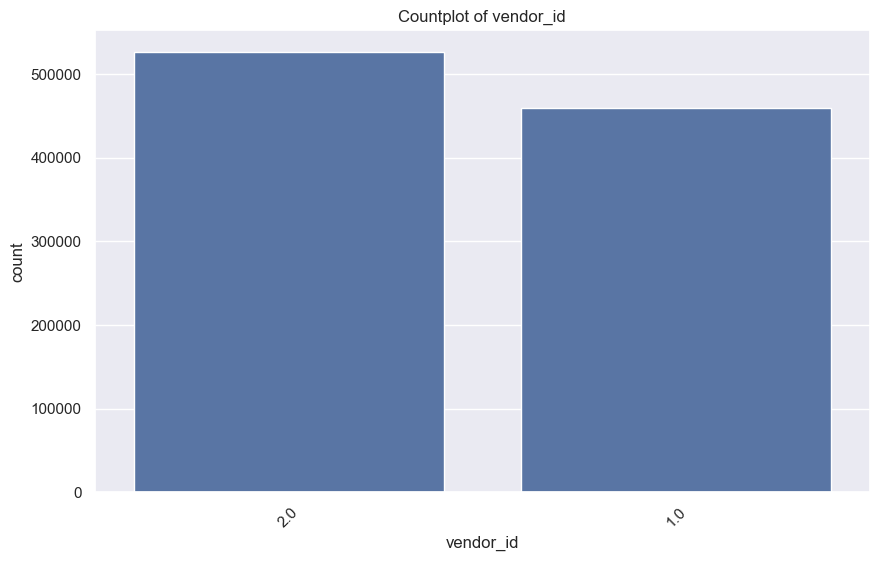

In [22]:
# visualize 'vendor_id'
plt.figure(figsize=(10,6))
sns.countplot(data=train,x=train.vendor_id,order=train.vendor_id.value_counts().index)
plt.xticks(rotation=45)
plt.title("Countplot of vendor_id")

- The countplot reveals that the distribution between the two vendor IDs is relatively balanced, with only a minor difference in the number of occurrences for each ID.

Text(0.5, 1.0, 'Countplot of passenger_count')

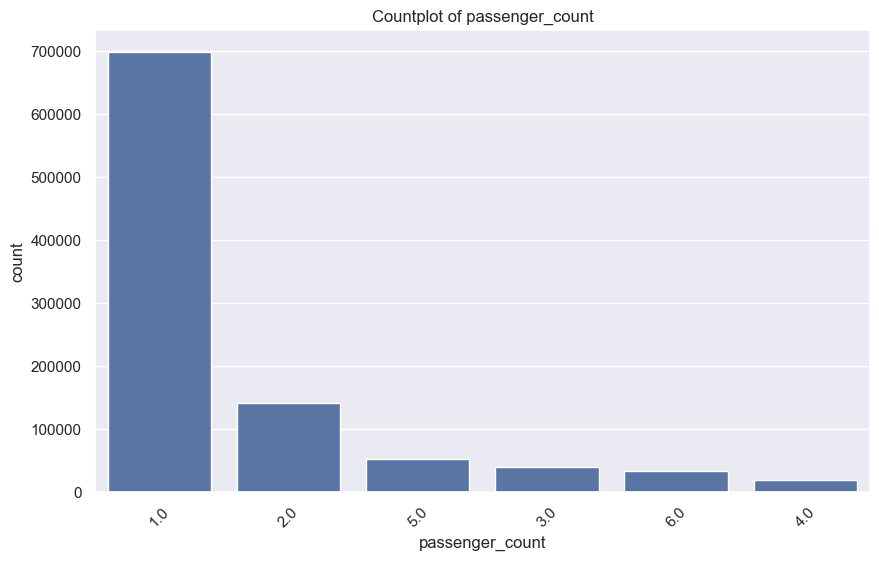

In [23]:
# visualize 'passenger_count'
plt.figure(figsize=(10,6))
sns.countplot(data=train,x=train.passenger_count,order=train.passenger_count.value_counts().index)
plt.xticks(rotation=45)
plt.title("Countplot of passenger_count")

- The countplot suggests that single-passenger trips are the most prevalent, indicating a preference or pattern where individual rides are more common, while trips with higher passenger counts are less frequent.
- The passenger count for ID 1 significantly exceeds that of the other IDs

## Numeric Data

### Trip Duration

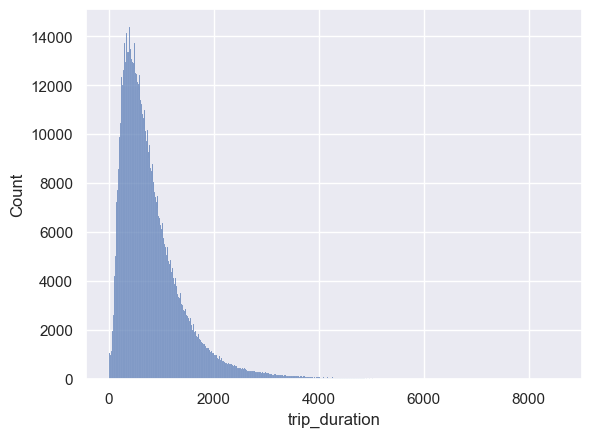

In [24]:
sns.histplot(data=train, x='trip_duration')
plt.xlabel('trip_duration')
plt.show()

A right-skewed distribution indicates that a log transformation is needed for **trip_duration**

In [25]:
train['log_trip_duration']=np.log1p(train.trip_duration)
test['log_trip_duration']=np.log1p(test.trip_duration)

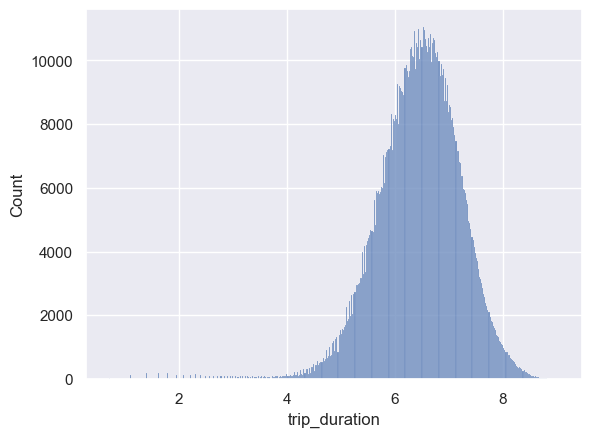

In [26]:
sns.histplot(data=train, x='log_trip_duration')
plt.xlabel('trip_duration')
plt.show()

### distance_haversine

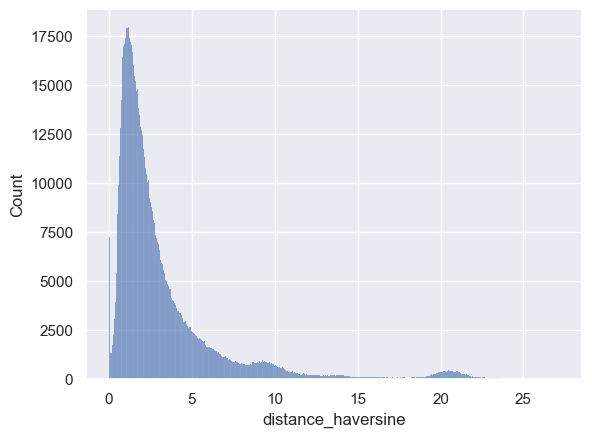

In [27]:
sns.histplot(data=train, x='distance_haversine')
plt.xlabel('distance_haversine')
plt.show()

A right-skewed distribution indicates that a log transformation is needed for **distance_haversine**

In [28]:
train['log_distance_haversine'] = np.log1p(train.distance_haversine)
test['log_distance_haversine'] = np.log1p(test.distance_haversine)

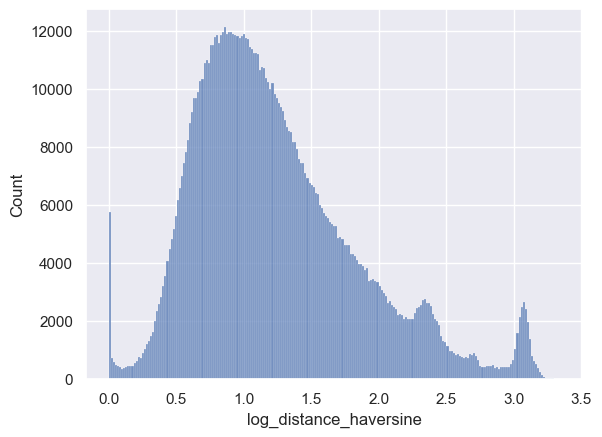

In [29]:
sns.histplot(data=train, x='log_distance_haversine')
plt.xlabel('log_distance_haversine')
plt.show()

### distance_dummy_manhattan

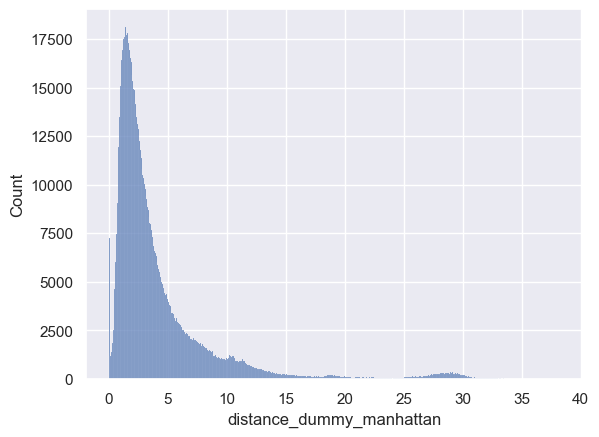

In [30]:
sns.histplot(data=train, x='distance_dummy_manhattan')
plt.xlabel('distance_dummy_manhattan')
plt.show()

- A right-skewed distribution indicates that a log transformation is needed for **distance_dummy_manhattan**

In [31]:
train['log_distance_dummy_manhattan'] = np.log1p(train.distance_dummy_manhattan)
test['log_distance_dummy_manhattan'] = np.log1p(test.distance_dummy_manhattan)


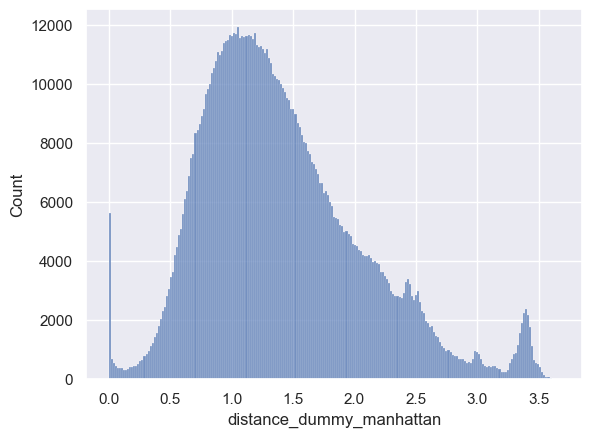

In [32]:
sns.histplot(data=train, x='log_distance_dummy_manhattan')
plt.xlabel('distance_dummy_manhattan')
plt.show()

### drop columns

In [33]:
train.drop(columns=['id','pickup_datetime','pickup_latitude','pickup_longitude',
                   'dropoff_latitude','dropoff_longitude','distance_haversine','distance_dummy_manhattan',
                   'trip_duration'],inplace=True)

test.drop(columns=['id','pickup_datetime','pickup_latitude','pickup_longitude',
                   'dropoff_latitude','dropoff_longitude','distance_haversine','distance_dummy_manhattan',
                   'trip_duration'],inplace=True)

In [34]:
train.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'DayofMonth',
       'dayofweek', 'month', 'hour', 'dayofyear', 'direction',
       'pickup_cluster', 'dropoff_cluster', 'log_trip_duration',
       'log_distance_haversine', 'log_distance_dummy_manhattan'],
      dtype='object')

### visualize features vs target

In [35]:
# Note, it will map the available 2 classes to {0, 1}
train = pd.get_dummies(train, columns=['store_and_fwd_flag'])

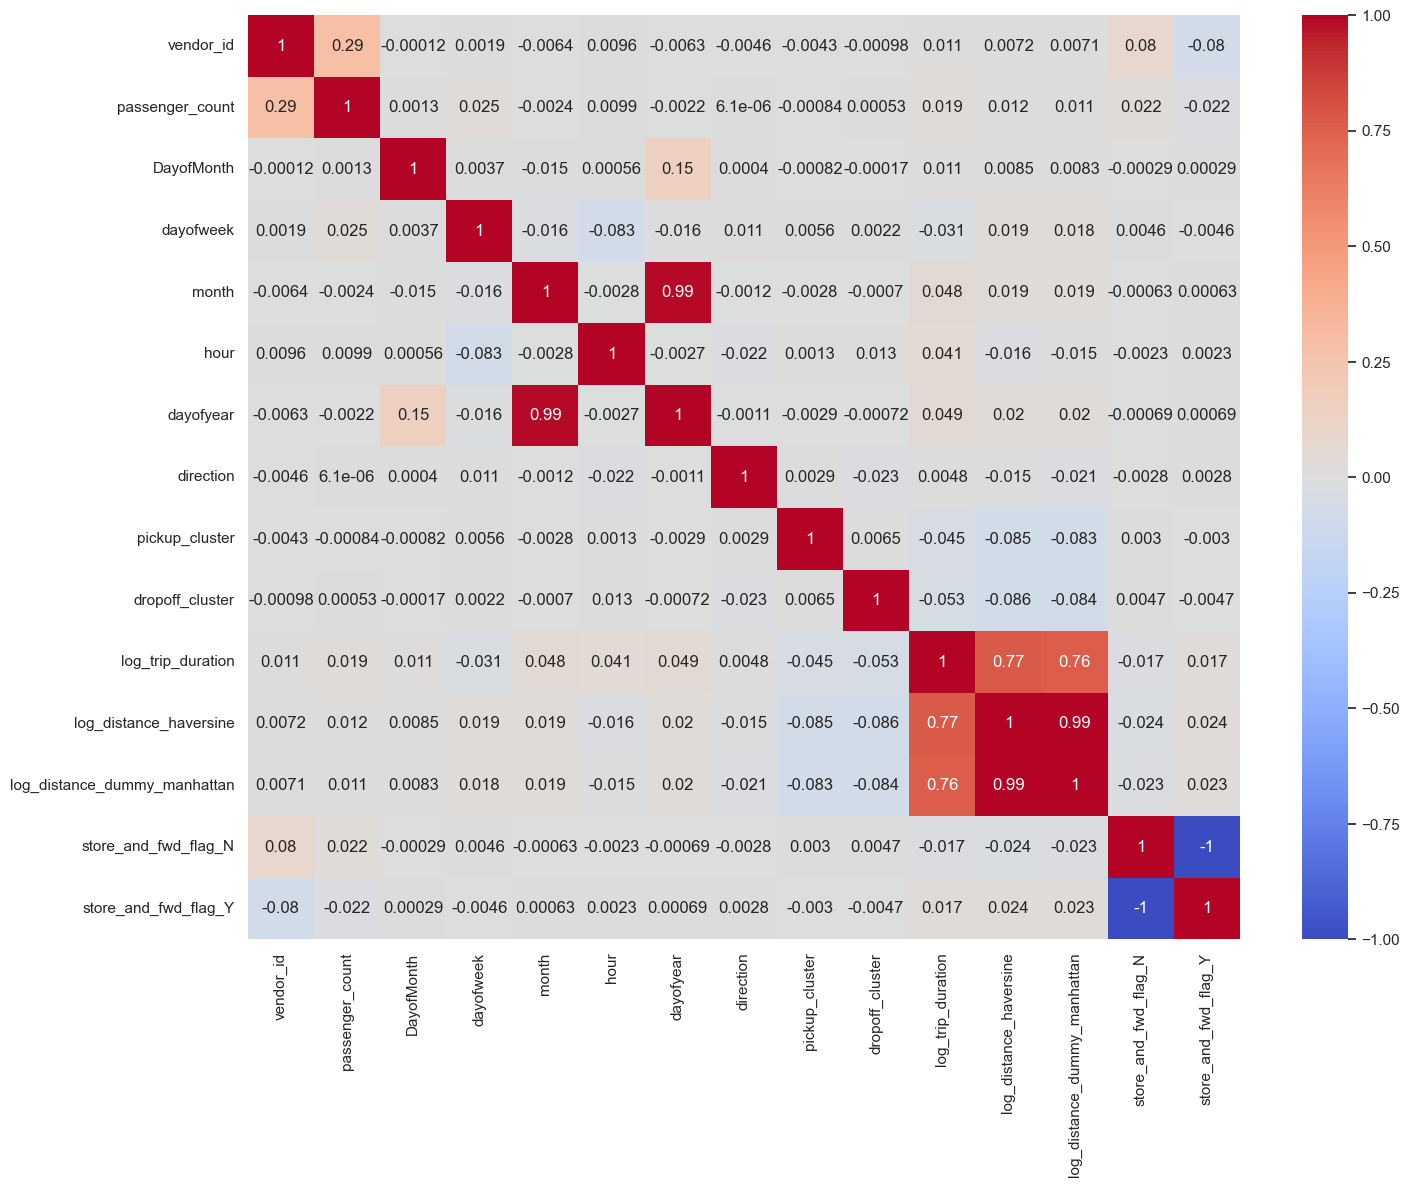

In [36]:
heatmap_df = train

plt.figure(figsize=(16, 12))
sns.heatmap(data=heatmap_df.corr(), annot=True, cmap="coolwarm")
plt.show()

we finshed the EDA to understand the data and that's the time for the model